# **MVGSC - [LH 2025-11] Desafio de Ciência de Dados**

---


## 0. Configuração Inicial

In [ ]:
# Instalação de bibliotecas necessárias (somente na primeira execução)
!pip install ydata-profiling scikit-learn seaborn matplotlib pandas numpy joblib

In [ ]:
# Montagem do Google Drive para acesso aos arquívos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
print(os.getcwd()) # Exibir diretório atual
print(os.listdir()) # Listar arquivos para confirmar acessibilidade do dataset

/content
['.config', 'requirements.txt', 'relatorio_EDA_filmes.html', 'drive', 'sample_data']


## 1. Importação de bibliotecas

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import mean_absolute_error ,mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import joblib
import pickle

## 2. Carregamento dos dados

In [64]:
df = pd.read_csv('/content/drive/MyDrive/[LH 2025-11] Desafio de Ciência de Dados/LH_CD_MARCUS_VINICIUS_GONCALVES_DE_SOUZA_COUTO/classificacao_filmes_imdb.csv')
df.info() # Exibir informações sobre tipos de dados e valores nulos
df.describe() # Estatísticas básicas
df.head() # Primeiras linhas do dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


## 3. Limpeza e tratamento dos dados

In [65]:
# Conversão da coluna "Gross" para valor numérico através da remoção de caracteres não numéricos
df['Gross'] = pd.to_numeric(df['Gross'].astype(str).str.replace('[^0-9]', '', regex=True), errors='coerce')

# Conversão da coluna "Runtime" para número através da remoção de " min"
df['Runtime'] = df['Runtime'].str.replace(' min', '', regex=False).astype(float)

# Definição de variáveis preditoras e definição de variável-alvo, respectivamente
features = ['Gross', 'Meta_score', 'Runtime', 'No_of_Votes']
target = 'IMDB_Rating'

# Remoção de linhas com valores nulos na variável-alvo
df = df.dropna(subset=[target])

# Criação de variáveis independentes (X) e dependente (y)
X = df[features].copy()
y = df[target].values

In [66]:
# Separação de variáveis com transformação logarítmica das demais
log_cols = ['Gross', 'No_of_Votes']
other_cols = ['Meta_score', 'Runtime']

# Pipeline para variáveis com transformação logarítmica
num_log = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log1p', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', StandardScaler())
])

# Pipeline para variáveis sem transformação logarítmica
num_other = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combinador de pipelines em um único pré-processador de dados
preprocessor = ColumnTransformer([
    ('log_num', num_log, log_cols),
    ('other_num', num_other, other_cols)
])

## 4. Análise Exploratória dos  (EDA)

Foi executada a Análise Exploratória de Dados para compreender distribuições, relações e correlações entre variáveis.

**Principais descobertas:**
- `IMDB_Rating` possui média ≈ 7.94, com leve concentração entre 7 e 8.
- Os dados referentes ao número de votos e ao faturamento apresentaram assimetria considerável, portanto, foi aplicada a transformação `log1p` em ambas as variáveis.  
- Dados ausentes tratados: faturamento e média ponderada de todas as críticas tiveram valores nulos descartados.  

**Hipóteses levantadas:**
1. Popularidade (`No_of_Votes`) está diretamente associada a maior faturamento e estabilidade da nota.
2. Filmes com `Meta_score` alto possuem mais probabilidade de obter nota IMDb mais alta.

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 16/16 [00:00<00:00, 42.28it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

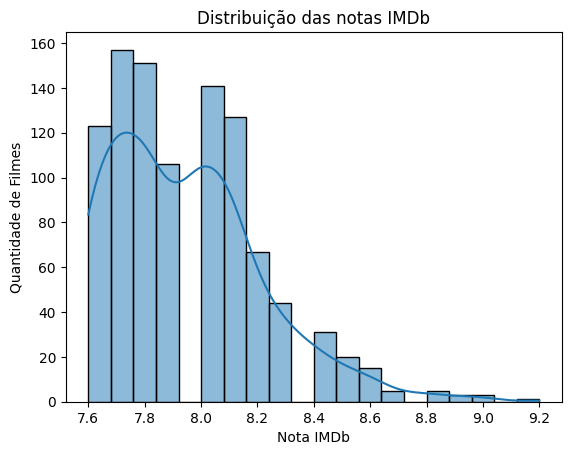

In [67]:
# Relatório automatizado para análise exploratória de dados
profile = ProfileReport(df, title="Relatório EDA de Análise de Dados - Classificação de Filmes", minimal=True)
profile.to_file("relatorio_EDA_filmes.html")

# Exemplificação de gráfico simples: Distribuição das notas IMDb
sns.histplot(df['IMDB_Rating'], kde=True, bins=20)
plt.xlabel('Nota IMDb')
plt.ylabel('Quantidade de Filmes')
plt.title('Distribuição das notas IMDb')
plt.show()

### 4.1. Recomendações de Filme

Para uma pessoa que não conheço, eu recomendaria **filmes em geral com alta nota crítica**

**Critérios observados:**
- `Meta_score` ≥ 75  
- `No_of_Votes` no top 25%

Os filmes analisados obtiveram, em média, um bom faturamento histórico e notas IMDb acima de 8.0.

### 4.2. Fatores para Alto Faturamento

Principais fatores identificados para faturamento elevado:
1. **Número de votos:** quanto maior o engajamento, maior bilheteria.  
2. **Média ponderada de todas as críticas:** uma ótima recepção crítica é capaz de incrementar o faturamento do filme em questão.

Recomendação: investir em projetos com **boa crítica** e **lançamento em datas estratégicas**, além de um **elenco renomado**.

### 4.3. Insights da Coluna Overview

Durante a execução deste desafio, não foi possível desenvolver um modelo robusto para extrair informações preditivas da coluna Overview devido a limitações de tempo e recursos computacionais. Esta variável específica, em se tratando de dados textuais, exigiria uma etapa adicional de pré-processamento e a aplicação de técnicas de Processamento de Linguagem Natural (PLN), por meio de representações semânticas mais modernas, como embeddings de linguagem.

Alternativamente, realizou-se somente uma análise exploratória básica, com a utilização de regras simples com base em palavras-chave para a devida identificação de possíveis correlações entre determinados termos e gêneros específicos de filmes.

Embora tal abordagem não tenha finalidade preditiva, isto indica o potencial dessa variável para futuras análises. Em uma situação real, recomenda-se a aplicação de técnicas mais sofisticadas, combinando algoritmos de classificação e PLN, para capturar com mais eficácia as informações contidas na coluna Overview e avaliar seu impacto no desempenho do modelo.

## 5. Pré-Processamento: Treinamento e Teste

In [68]:
# Geração de pipeline inicial com pré-processamento e modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Validação cruzada com o intuito de estimar desempenho do modelo
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = -cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
print('CV MAE (5-fold):', scores.mean(), scores.std())

# Espaço de busca para hiperparâmetros do Random Forest
Param_dist = {
    'model__n_estimators': [100, 200, 400, 600, 800],
    'model__max_depth': [None, 10, 20, 30, 40],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5, 10],
    'model__max_features': ['sqrt', 'log2', None]
}

# Busca aleatória com a finalidade de encontrar melhores hiperparâmetros
rnd_search = RandomizedSearchCV(
    pipeline,
    param_distributions=Param_dist,
    n_iter=10,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
    )
rnd_search.fit(X, y)

# Resultados da busca
print('Melhor MAE:', -rnd_search.best_score_)
print('Melhores parâmetros:', rnd_search.best_params_)

# Pipeline final com melhores hiperparâmetros
best_pipeline = rnd_search.best_estimator_

CV MAE (5-fold): 0.15582370351758806 0.005097272483762081
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor MAE: 0.1575768605453646
Melhores parâmetros: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'log2', 'model__max_depth': None}


## 6. Modelagem

**Tipo de problema:** Análise de Regressão (variável dependente: IMDB_Rating).  

**Modelos testados:** Regressão Linear, Árvores de Decisão e Random Forest.  

**Decisão final:** `RandomForestRegressor` → melhor opção entre robustez e desempenho.  

**Pré-processamento aplicado:**
- `log1p` nas variáveis de faturamento e número de votos para lidar com assimetria  
- Imputação de valores ausentes/nulos por mediana  

**Validação:** 5-fold Cross Validation. → Validação Cruzada
**Principal Métrica:** MAE (interpretação direta em pontos IMDb).  

**Melhores parâmetros encontrados:**  

- n_estimators=200
- min_samples_split=10
- min_samples_leaf=2
- max_features='log2'
- max_depth=None

**Resultados (5-fold CV):**  
- CV MAE: 0.1558 ± 0.0051  
- MAE final: 0.1623  
- RMSE: 0.2048  
- R²: 0.3609

In [69]:
# Divisão em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log_num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log1p',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Gross', 'No_of_Votes']),
                                                 ('other_num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Meta_score', 'Runtime'])])),
                ('model',
                 RandomForestRegressor(max_features='log2', min_samples_leaf=2,
                                       min_samples_split=10, n_estimators=200,
                                       random_state=42))])

## 7. Avaliação do Modelo

MAE: 0.1623
RMSE: 0.2048
R²: 0.3609


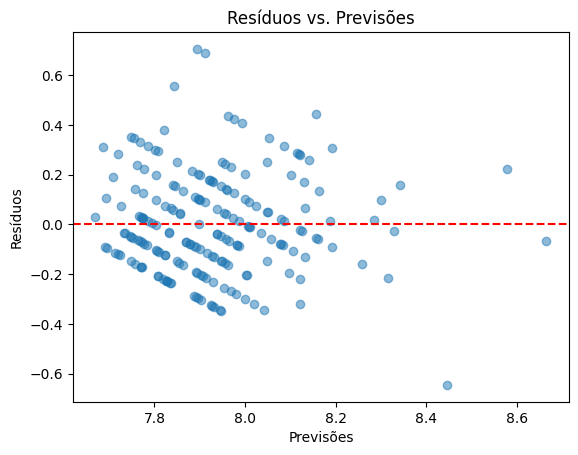

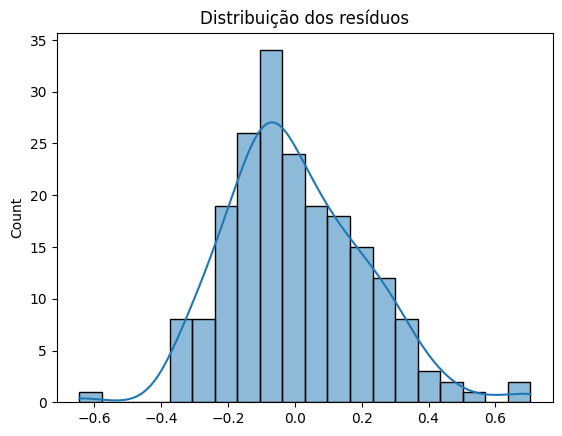

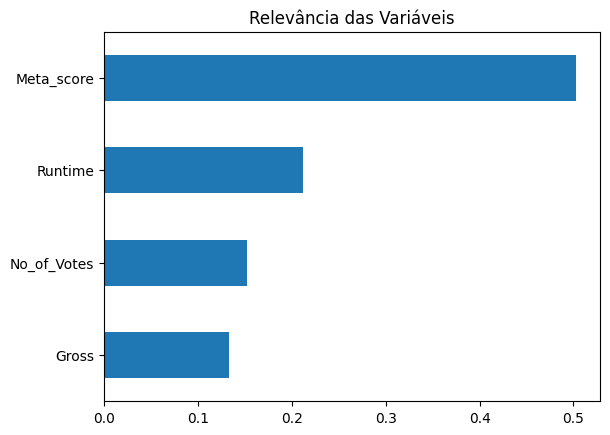

Gross: 0.1329
Meta_score: 0.5032
Runtime: 0.2114
No_of_Votes: 0.1525


In [70]:
# Variável responsável por efetuar previsões no conjunto de teste
y_pred = best_pipeline.predict(X_test)

# Cálculos de métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Calculate RMSE by taking the square root of the mean squared error
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')

# Gráficos de resíduos
resid = y_test - y_pred
plt.scatter(y_pred, resid, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Previsões')
plt.show()

sns.histplot(resid, kde=True, bins=20)
plt.title('Distribuição dos resíduos')
plt.show()

# Gráfico de Relevância das Variáveis
model = best_pipeline.named_steps['model']
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=features).sort_values(ascending=True)
feature_importances.plot(kind='barh')
plt.title('Relevância das Variáveis')
plt.show()
for feature, importance in zip(features, importances):
    print(f'{feature}: {importance:.4f}')

## 8. Processamento de modelagem

In [71]:
caminho = '/content/drive/MyDrive/[LH 2025-11] Desafio de Ciência de Dados/LH_CD_MARCUS_VINICIUS_GONCALVES_DE_SOUZA_COUTO/IMDb_pipeline.pkl'

# Salvamento do arquivo referente ao pipeline completo (pré-processamento + modelo)
joblib.dump(best_pipeline, caminho)

['/content/drive/MyDrive/[LH 2025-11] Desafio de Ciência de Dados/LH_CD_MARCUS_VINICIUS_GONCALVES_DE_SOUZA_COUTO/IMDb_pipeline.pkl']

In [72]:
# Descarregamento do arquivo referente ao pipeline completo (pré-processamento + modelo)
from google.colab import files
files.download(caminho)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
# Teste de carregamento de arquivo
best_pipeline = joblib.load(caminho)

In [74]:
# Salvamento de métricas em arquivo .txt
with open('/content/drive/MyDrive/[LH 2025-11] Desafio de Ciência de Dados/LH_CD_MARCUS_VINICIUS_GONCALVES_DE_SOUZA_COUTO/metricas_modelo.txt', 'w') as f:
    f.write(f'MAE: {mae:.4f}\n'),
    f.write(f'RMSE: {rmse:.4f}\n'),
    f.write(f'R²: {r2:.4f}\n')

## 9. Previsão específica

In [75]:
# Função preditora de notas para um novo filme
def prever_filme(modelo, gross, meta_score, runtime, no_of_votes):
    novo_filme = pd.DataFrame({
        'Gross': [gross],
        'Meta_score': [meta_score],
        'Runtime': [runtime],
        'No_of_Votes': [no_of_votes]
    })
    return modelo.predict(novo_filme)[0]

# Exemplo de aplicação
nota_prevista = prever_filme(best_pipeline, 14835707, 85, 130, 1850982)
print(f'Nota IMDb prevista para o filme: {nota_prevista:.2f}')

Nota IMDb prevista para o filme: 8.62


### 9.1. Previsão para The Shawshank Redemption


Características do filme:
- Ano: 1994
- Gênero: Drama
- Duração: 142 min
- Meta_score: 80
- Votos: 2.343.110
- Faturamento: 28.341.469  

**Predição obtida:** 8.74  

**Intervalo de confiança (± MAE):** 8.58 – 8.90  

Conclusão: O modelo prevê nota **muito próxima da real (9.3)**, mostrando boa capacidade preditiva.

## 10. Referências

Referências
*   Scikit-learn documentation - https://scikit-learn.org/stable/
*   "Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow"
*   ydata-profilling docs - https://docs.profiling.ydata.ai/latest/
*   IMDb: Um Sonho de Liberdade - https://www.imdb.com/pt/title/tt0111161/?ref_=nv_sr_srsg_0_tt_7_nm_0_in_0_q_The%2520Shawshank%2520Redemption%27